# Linear Regression - Top model according to the SCPM of -5.35	(dominance count 19)

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

# Feature importance
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_linreg_df_importances(scores):
    coefs = {}
    bias = {}
    coefs_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        coefs[index] = model.coef_.copy()
        bias[index] = model.intercept_.copy()

    for index, coefs_vec in coefs.items():
        coefs_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, coefs_vec)},
            index=[f"Coefficients - {index}"],
        )
        coefs_with_column.append(coefs_col)
    df_bias = pd.Series(bias)
    df_coefs = pd.concat(coefs_with_column)

    return df_coefs, df_bias

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "206",
    "Plant": "B",
    "Features": "Chemical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../data/processed/206/b.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.copy().drop(
    [
        "Cement_Type",
        "Blaine",
        "#200",
        "#325",
        "Final setting time",
        "Initial setting time",
        "CS1",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [8]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [9]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

## 1.3. Time Series Cross Validation

In [10]:
repeats = 1
n_splits = 5
gap = 0
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Time Series Split"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 1, "Gap": 0}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 1
n_splits: 5

******
[TRAIN]
******
RMSE: -1.412 (0.094)
MAE: -1.112 (0.047)
MAPE: -0.025 (0.001)
R2: 0.771 (0.059)


******
[TEST]
******
RMSE: -1.866 (0.413)
MAE: -1.443 (0.299)
MAPE: -0.033 (0.008)
R2: 0.477 (0.182)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [11]:
df_pred = pd.DataFrame()
df_pred["DATE"] = dates.copy()
df_pred["CS28"] = y.copy()
df_pred["CS28_PRED"] = np.nan
df_pred["SET"] = ""
df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])


for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    # results = scores["estimator"][0].predict(x.loc[index_preds])
    results = pipeline.predict(x.loc[index_preds])
    df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
    df_pred.loc[index_train, "SET"] = "TRAIN"
    df_pred.loc[index_test, "SET"] = "TEST"
df_pred = df_pred.dropna()

<IPython.core.display.Javascript object>

In [12]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
0,2020-01-02,39.2875,42.997043,TRAIN
1,2020-01-02,48.0475,47.292065,TRAIN
2,2020-01-04,49.3350,47.593734,TRAIN
3,2020-01-07,41.8425,44.058796,TRAIN
4,2020-01-07,47.3150,47.206163,TRAIN
...,...,...,...,...
1164,2023-02-22,39.4950,42.375041,TEST
1165,2023-02-23,41.3350,41.933665,TEST
1166,2023-02-25,45.6275,42.024748,TEST
1167,2023-02-28,40.4175,42.125565,TEST


<IPython.core.display.Javascript object>

In [13]:
df_pred

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE
0,2020-01-02,39.2875,42.997043,TRAIN,CPIV32RS
1,2020-01-02,48.0475,47.292065,TRAIN,CPVARI
2,2020-01-04,49.3350,47.593734,TRAIN,CPVARI
3,2020-01-07,41.8425,44.058796,TRAIN,CPIV32RS
4,2020-01-07,47.3150,47.206163,TRAIN,CPVARI
...,...,...,...,...,...
1164,2023-02-22,39.4950,42.375041,TEST,CPIV32RS
1165,2023-02-23,41.3350,41.933665,TEST,CPIV32RS
1166,2023-02-25,45.6275,42.024748,TEST,CPIV32RS
1167,2023-02-28,40.4175,42.125565,TEST,CPIV32RS


<IPython.core.display.Javascript object>

In [14]:
# df_copy_merge = df_copy.merge(df_pred, left_index=True, right_index=True, how="left")
# df_copy_merge["COMPANY"] = 209
# df_copy_merge["PLANT"] = "S"
# for fold, (train_index, test_index) in enumerate(cv.split(x)):
#     df_copy_merge.loc[train_index, "FOLD"] = fold + 1
#     df_copy_merge.loc[test_index, "FOLD"] = fold + 1
# df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
# df_copy_merge.to_excel("local_model_linear_regression_btsscv_209_k.xlsx", index=False)
# df_copy_merge.to_csv("local_model_linear_regression_btsscv_209_k.csv", index=False)

<IPython.core.display.Javascript object>

In [15]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

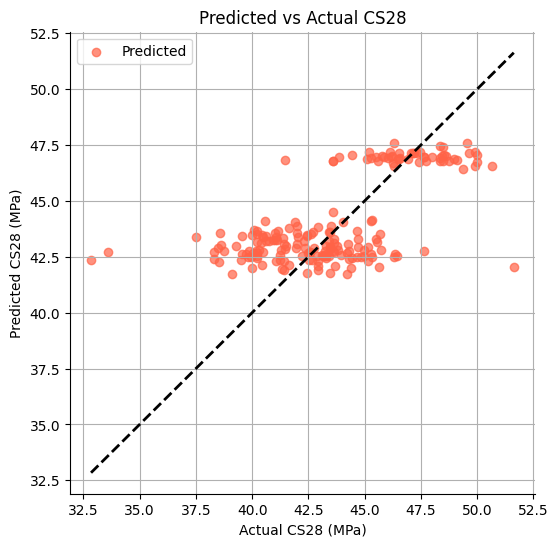

<IPython.core.display.Javascript object>

In [16]:
test_data = df_pred[df_pred["SET"] == "TEST"]

plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_206_b_local_cm_tiss_top_scpm_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


In [17]:
df["Cement_Type"].value_counts()

Cement_Type
CPVARI      598
CPIV32RS    571
Name: count, dtype: int64

<IPython.core.display.Javascript object>

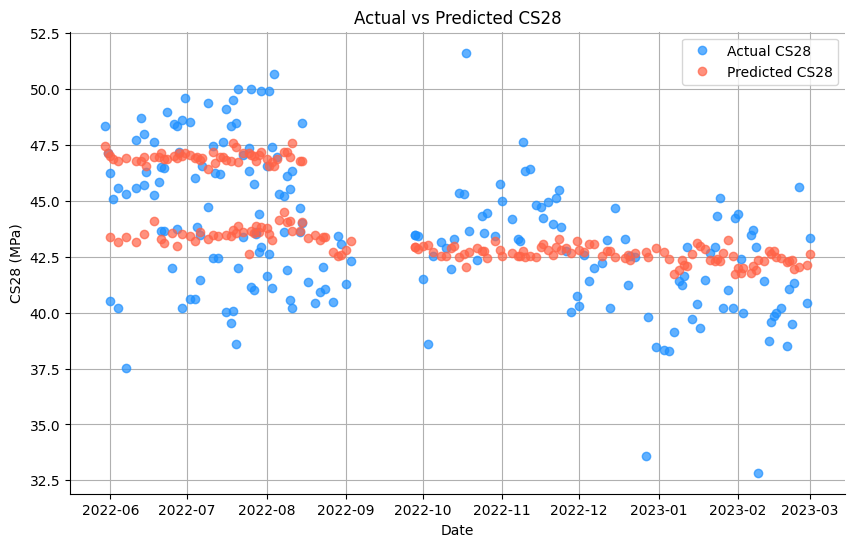

<IPython.core.display.Javascript object>

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend(loc="best")
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_206_b_local_cm_tiss_top_scpm_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [19]:
df_coefs, df_bias = get_linreg_df_importances(scores)
df_importances = df_coefs

<IPython.core.display.Javascript object>

In [20]:
df_importances

,MgO,SO3,Loss on Ignition,Insoluble Residue
Coefficients - 0,0.411912,-0.242536,-0.957617,-2.105001
Coefficients - 1,0.389802,-0.202949,-1.087037,-1.672161
Coefficients - 2,0.492791,-0.025725,-0.868237,-1.471792
Coefficients - 3,0.313657,-0.076254,-0.973841,-1.260086
Coefficients - 4,0.319062,-0.113768,-0.683629,-1.460584


<IPython.core.display.Javascript object>

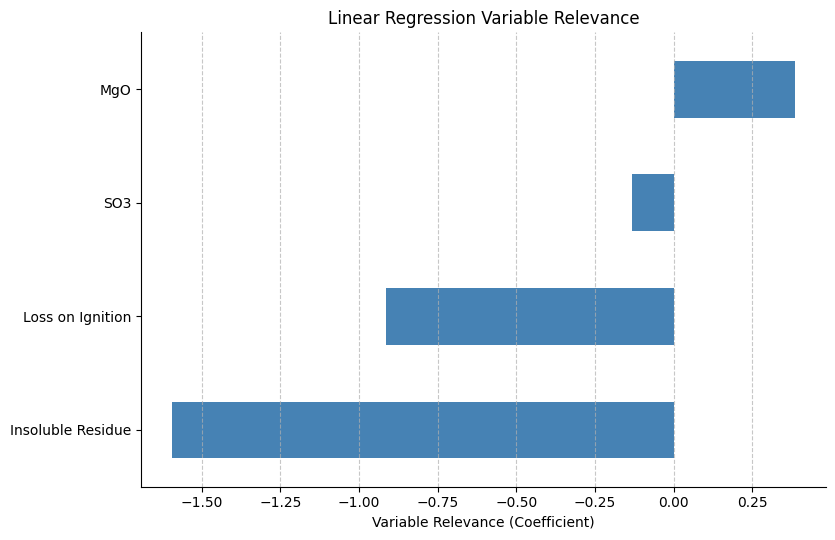

<IPython.core.display.Javascript object>

In [21]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Linear Regression Variable Relevance")
plt.xlabel("Variable Relevance (Coefficient)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

In [22]:
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

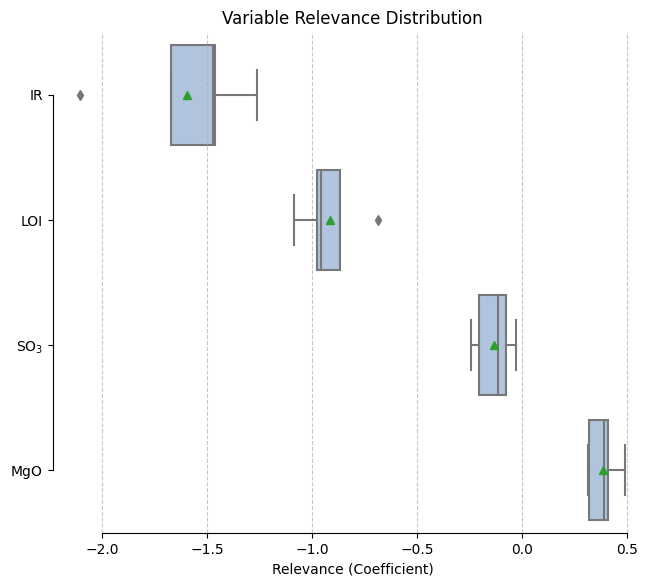

<IPython.core.display.Javascript object>

In [23]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 6.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Coefficient)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)

plt.savefig(
    "ecics_206_b_local_cm_tiss_top_scpm_dist_var_coef_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [24]:
df_importances

,MgO,SO3,Loss on Ignition,Insoluble Residue
Coefficients - 0,0.411912,-0.242536,-0.957617,-2.105001
Coefficients - 1,0.389802,-0.202949,-1.087037,-1.672161
Coefficients - 2,0.492791,-0.025725,-0.868237,-1.471792
Coefficients - 3,0.313657,-0.076254,-0.973841,-1.260086
Coefficients - 4,0.319062,-0.113768,-0.683629,-1.460584


<IPython.core.display.Javascript object>

In [25]:
df_importances.describe().T.sort_values(by=["mean"])

,count,mean,std,min,25%,50%,75%,max
Insoluble Residue,5.0,-1.593925,0.320727,-2.105001,-1.672161,-1.471792,-1.460584,-1.260086
Loss on Ignition,5.0,-0.914072,0.150491,-1.087037,-0.973841,-0.957617,-0.868237,-0.683629
SO3,5.0,-0.132246,0.089423,-0.242536,-0.202949,-0.113768,-0.076254,-0.025725
MgO,5.0,0.385445,0.073829,0.313657,0.319062,0.389802,0.411912,0.492791


<IPython.core.display.Javascript object>

In [26]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [27]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    scaler = pipeline.named_steps["transformer"]
    # Compute MDI importance
    # mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        scaler.transform(imputer.transform(x.iloc[test_idx])),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        # scoring="neg_mean_squared_error",
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

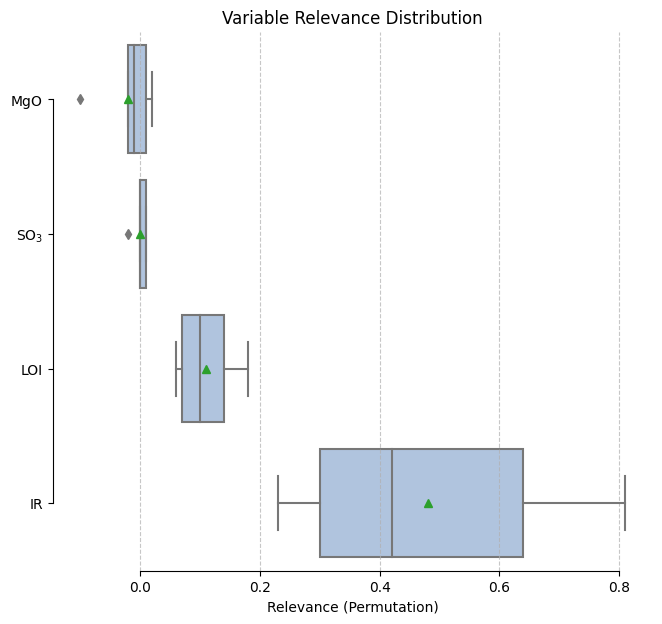

<IPython.core.display.Javascript object>

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Convert lists to DataFrames
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(columns={"Loss on Ignition": "LOI"})


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 7))

# Create boxplot
sns.boxplot(
    data=perm_importances_df_plot.round(2),
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)

# Set x-axis label and title
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")

# Add gridlines for x-axis
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Format x-axis to show 1 decimal place
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.1f}"))

# Adjust the layout to prevent label cut-off
plt.subplots_adjust(left=0.3)

# Save the plot
plt.savefig(
    "ecics_206_b_local_cm_tiss_top_scpm_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# Show the plot
plt.show()

# Reset all rcParams to their default values
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [29]:
perm_importances_df.describe().round(4).T.sort_values(by="mean")

,count,mean,std,min,25%,50%,75%,max
MgO,5.0,-0.0217,0.0465,-0.0990,-0.0241,-0.0136,0.0113,0.0171
SO3,5.0,0.0014,0.0097,-0.0152,0.0027,0.0030,0.0073,0.0091
LOI,5.0,0.1134,0.0511,0.0597,0.0749,0.1039,0.1448,0.1840
Insoluble Residue,5.0,0.4778,0.2431,0.2251,0.2973,0.4176,0.6397,0.8096


<IPython.core.display.Javascript object>

In [30]:
perm_importances_df

,MgO,SO3,LOI,Insoluble Residue
0,-0.024140,0.002724,0.074863,0.809605
1,-0.013620,0.009076,0.183970,0.639706
2,-0.098957,0.002967,0.059664,0.225061
3,0.017081,0.007316,0.144813,0.297282
4,0.011334,-0.015204,0.103904,0.417567


<IPython.core.display.Javascript object>